## 视觉检测 练习
本笔记本介绍了从数据加载、模型训练、模型部署和测试的一套完整流程，并且提供了一套基本的视觉检测模型。根据指令对本笔记本中的相应代码区域进行修改并执行，即可生成并且部署一套视觉检测服务。参赛选手需要根据实际的数据情况，对模型进行调优。

In [1]:
import json
import os
import requests
import io
import PIL
import PIL.Image as PImage
from PIL import ImageEnhance
import math
from pprint import pprint
import glob
from collections import Counter
from datetime import datetime
import shutil
import numpy as np
import math

## 定义配置参数
里面除了图片高度和宽度，其他参数均不需要修改调整

In [3]:
#大数据平台地址，无需修改
API_BASE_URL = 'http://fireeye-test-backend-container:9090/api/'  
#tf modelserver的地址，无需修改
TF_SERVING_BASE_URL = 'http://fireeye-test-model-container:8501/'  
# 根据云平台中的视觉任务实际的编号进行设置
task_id='1ac1e8a095df4611af387d9934799251'  
# 注意，/workspace为工作目录的根目录
image_dir = './image'  
# 根据大数据平台web中的任务管理显示情况设定
id_code_mapping = {  
    'dbee3deebc5444f5b011da4e5518752c': '0',
    'edb4cb51d54644c08aa122d3f041bb0a': '1'
}
# 图片高度，单位为像素
img_height = 218  
# 图片宽度，单位为像素
img_width = 175  

然后，我们通过调用/image/count服务查看任务类别中的人工标注的图片数量。

In [4]:
num_images = requests.get(
    url=API_BASE_URL+'image/count', 
    params=dict(
        task_id=task_id,
        has_truth=True
    )
).json()

print('该任务类别下的图片数量：',num_images)

该任务类别下的图片数量： 310


如果上述步骤显示图片数量过小，则有可能无法正常进行后续步骤，同学们需要采集一定数量的图片之后才能继续后续步骤。

接着，我们调用/image服务查看图片记录的详细信息

In [5]:
import pprint

def get_image_records(task_id):
    resp = requests.get(
        url=API_BASE_URL+'image', 
        params=dict(
            task_id=task_id,
            has_truth=True            
        )
    )
    
    if resp.status_code == 200:
        return resp.json()
    else:
        raise RuntimeError(resp.text)
    
image_records=get_image_records(task_id)
print(len(image_records))
pprint.pprint(image_records[:2])

310
[{'id': 'f22fd70997654d4fb7e3649c2b2e344b',
  'platform_id': '7f0d3278fa7b47968a085618bb1513b8',
  'slot': '1',
  'task_id': '1ac1e8a095df4611af387d9934799251',
  'time': 1686798996.492,
  'truth_id': 'dbee3deebc5444f5b011da4e5518752c'},
 {'id': '7de796dfbc71480cbfa0284098efc899',
  'platform_id': '7f0d3278fa7b47968a085618bb1513b8',
  'slot': '1',
  'task_id': '1ac1e8a095df4611af387d9934799251',
  'time': 1686798996.481,
  'truth_id': 'dbee3deebc5444f5b011da4e5518752c'}]


然后，我们可以调用/image/\{image_id\}服务查看每个图片的内容。

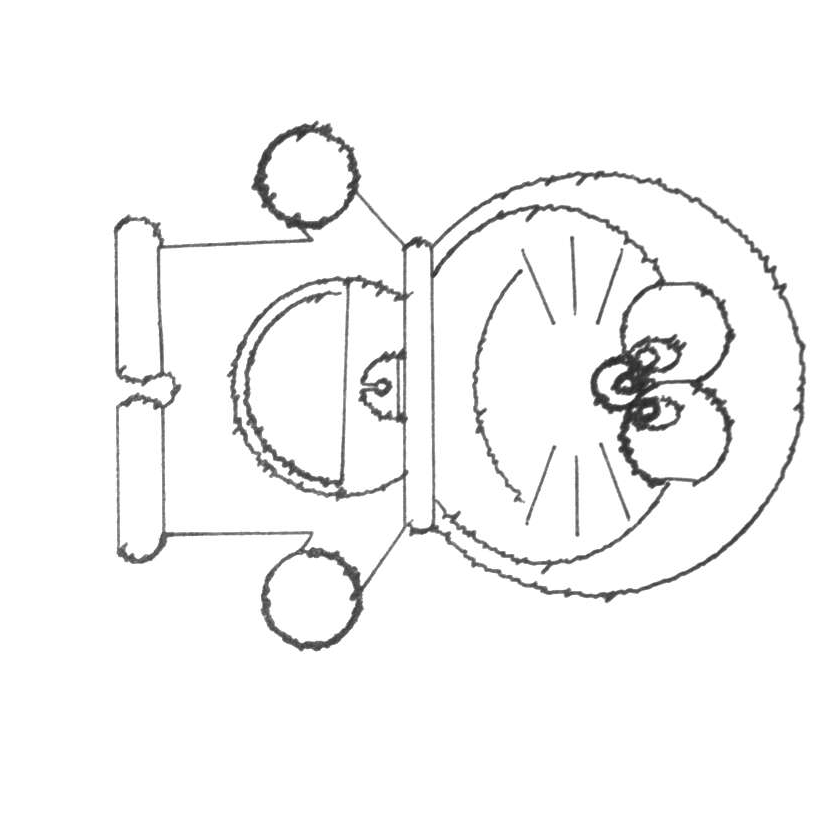

In [6]:
def get_image_by_id(id):
    r = requests.get(url=API_BASE_URL+'image/'+id)
    if r.status_code == 200:
        return PIL.Image.open(io.BytesIO(r.content))
    else:
        raise RuntimeError(r.text)
img = get_image_by_id(image_records[0]['id']) 
img.show()

## 配置下载数据集
配置训练集、验证集和测试集

In [7]:
import numpy as np
import math

task_dir = os.path.join(image_dir, task_id)
train_dir = os.path.join(task_dir, 'train')
dev_dir = os.path.join(task_dir, 'dev')
test_dir = os.path.join(task_dir, 'test')

id_code_mapping = {  # 根据web界面显示情况设定
    'dbee3deebc5444f5b011da4e5518752c': '0',
    'edb4cb51d54644c08aa122d3f041bb0a': '1'
}
np.random.seed(123)
for record in image_records:
    if record['truth_id'] is None:
        continue
    if np.random.uniform(0, 1) < 0.6:  # 需要通过修改数值来控制测试集的比例
        dst_dir = os.path.join(train_dir, id_code_mapping[str(record['truth_id'])])
    elif np.random.uniform(0, 1) < 0.5: 
        dst_dir = os.path.join(dev_dir, id_code_mapping[str(record['truth_id'])])
    else:
        dst_dir = os.path.join(test_dir, id_code_mapping[str(record['truth_id'])])
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
    image_id = record['id']
    dst = os.path.join(dst_dir, image_id +'.png')
    resp = requests.get(API_BASE_URL + f'image/{image_id}')
    if resp.status_code != 200:
        raise ValueError('Failed to get image: '+str(resp))
    in_stream = io.BytesIO(resp.content)
    pimage = PImage.open(in_stream)
    pimage.save(dst)

如果上述命令执行成功，用户可以在<I>/tf/data/slot0</I>目录下查看到相应的图片。
用户也可以通过下面的程序查看目录下的图片数量。

In [10]:
import pathlib

train_image_count = len(list(pathlib.Path(train_dir).glob('*/*.png')))
dev_image_count = len(list(pathlib.Path(dev_dir).glob('*/*.png')))
test_image_count = len(list(pathlib.Path(test_dir).glob('*/*.png')))
print(train_image_count, dev_image_count, test_image_count)

284 133 109


首先，我们引入tensorflow相关的Python包

In [11]:
import tensorflow as tf
from tensorflow.keras import layers

print(tf.__version__)


2.8.2


然后，我们需要对训练图片的大小以及每一批处理图片的数量做相应的设置。

In [12]:
batch_size = 16 # 每一批所处理的图片数量,可以根据需要进行更改

## 加载数据集
下面构建训练集，验证集和测试集。

In [14]:
def build_dataset(data_dir, target=None):
    all_images = []
    all_labels = []
    for i in range(4):
        if target is not None and i != target:
            continue
        images = glob.glob(os.path.join(data_dir, f'{i}/*.png'), recursive=True)
        all_images.extend(images)
        all_labels.extend([i] * len(images))
    ds = tf.data.Dataset.from_tensor_slices((all_images, all_labels))
    ds = ds.map(lambda x,y: (tf.io.encode_base64(tf.io.read_file(x)) ,y))
    ds = ds.shuffle(100, seed=123)
    ds = ds.batch(batch_size)
    return ds


train_ds = build_dataset(train_dir)
dev_ds = build_dataset(dev_dir)
test_ds = build_dataset(test_dir)

运行下面的程序可以查看数据集中的类别以及维度

In [15]:
print(train_ds)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
(16,)
(16,)


## 模型训练
接下来，我们用tensorflow构建图像分类模型。同学们可以根据自己的知识对模型的结构进行修改。

In [16]:

def process_base64_image(s):
    img = tf.io.decode_base64(s)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, (img_height, img_width), antialias=True)    
    return img

# 构建模型
model = tf.keras.Sequential([
    layers.Lambda(
            (
                lambda x: tf.map_fn(
                    process_base64_image,
                    x,
                    fn_output_signature=tf.TensorSpec(shape=(int(img_height), int(img_width), 3), dtype=tf.float32))
            ),
            name='decode_base64_png'
        ),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])


In [17]:
# 编译模型，选择损失函数、优化器和性能指标
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

下面开始训练模型。

In [18]:
# 训练模型
epochs = 3
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=dev_ds
)

Epoch 1/3
18/18 [==============================] - 9s 333ms/step - loss: 5.1010 - accuracy: 0.5282 - val_loss: 4.3569 - val_accuracy: 0.5113
Epoch 2/3
18/18 [==============================] - 5s 240ms/step - loss: 5.1010 - accuracy: 0.5282 - val_loss: 4.3569 - val_accuracy: 0.5113
Epoch 3/3
18/18 [==============================] - 4s 216ms/step - loss: 5.1010 - accuracy: 0.5282 - val_loss: 4.3569 - val_accuracy: 0.5113


完成模型训练后我们可以测试模型识别准确率

In [19]:
model.evaluate(test_ds)

7/7 [==============================] - 1s 74ms/step - loss: 5.5961 - accuracy: 0.5229


[5.596051216125488, 0.5229358077049255]

# 如果对训练结果满意，我们可以部署模型。

In [17]:
import pytz
from datetime import datetime

model_version =  datetime.now(pytz.timezone('Asia/Shanghai')).strftime('%Y%m%d%H%M%S')
tf.keras.models.save_model(
    model,
    f'/models/slot1/{model_version}/',
    overwrite=True,
)

2023-06-28 03:58:12.473543: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /models/slot1/20230628115812/assets


模型部署的地址必须为 <I>/models/slot1/\<版本号\> </I> 的格式,其中版本号必须为数字，而其对应的服务地址为“<I>http://fireeye-prod-model-container:8501/v1/models/image/versions/<版本号>:predict</I>”。在部署完成后，我们需要在web平台的“任务管理”页面中配置相应的服务地址。
    
注意，tensorflow-serving在加载模型的时候会自动加载版本号最高的模型，并卸载低版本号的模型。因此，每次部署新部署模型时需要递增版本号。由于我们的系统已经预置了一个低精度版本的模型，并且将版本号设置为1，所以用户在部署自定义模型时应当至少将版本号设置为2。而且，tensorflow-serving卸载旧版本模型并加载新版本模型的过程往往需要数十秒的时间，在次期间对模型发送请求会得到“Servable not found for request”的错误。用户可以使用docker logs image-serving-container查看是否已经加载完毕。

接下来，我们可以通过想TensorFlow Serving发出HTTP请求来验证模型的部署效果。

In [22]:
import base64

def predict_image(images):    
    bimages = []
    for image in images:
        with open(image, 'rb') as  fimage:
            content = fimage.read()
        bimage = base64.urlsafe_b64encode(content).decode()
        bimages.append(bimage)
    req_data ={
      'inputs': bimages,
    }
    response = requests.post(TF_SERVING_BASE_URL+f'v1/models/slot1/versions/{model_version}:predict', # 根据部署地址填写
                             json=req_data,
                             headers={"content-type": "application/json"})
    if response.status_code != 200:
        raise RuntimeError('Request tf-serving failed: ' + response.text)
    resp_data = json.loads(response.text)    
    if 'outputs' not in resp_data \
                        or type(resp_data['outputs']) is not list:
        raise ValueError('Malformed tf-serving response')
    outputs = np.argmax(resp_data['outputs'], axis=1).tolist()
    return outputs


def test_image_model(test_dir, code, batch_size=10):    
    images = list(pathlib.Path(test_dir).joinpath(str(code)).glob('./*.png')) 
    codes = []
    for step in range(math.ceil(len(images)/batch_size)):
        outputs = predict_image(images[step*batch_size:(step+1)*batch_size])
        for i, o in zip(images, outputs):            
            if o != code:
                print('错误图片：', i)
        codes.extend(outputs)
    accuracy = round(codes.count(code) / len(codes), 4)
    return accuracy, codes

accuracy, codes = test_image_model(test_dir, 0)
print('类别0的准确率', accuracy)
print('类别0的测试结果', codes)
accuracy, codes = test_image_model(test_dir, 1)
print('类别1的准确率', accuracy)
print('类别1的测试结果', codes)

错误图片： image/1ac1e8a095df4611af387d9934799251/test/0/28cb5dd1-c5ed-45d9-aedc-71549c0ec867.png
错误图片： image/1ac1e8a095df4611af387d9934799251/test/0/d5cdf3f00d27471c9045f323e4d5c276.png
错误图片： image/1ac1e8a095df4611af387d9934799251/test/0/09303778502442448ec512c697716b22.png
错误图片： image/1ac1e8a095df4611af387d9934799251/test/0/e6078b28f98c4ee0842608f0954fc6e7.png
错误图片： image/1ac1e8a095df4611af387d9934799251/test/0/361e7d72590140828358b92f6e73c813.png
错误图片： image/1ac1e8a095df4611af387d9934799251/test/0/90b0ee0d-7dec-4593-ade1-ba576cc42b76.png
错误图片： image/1ac1e8a095df4611af387d9934799251/test/0/00fa9ae9-d988-43d7-b1e2-0df30b70a76c.png
错误图片： image/1ac1e8a095df4611af387d9934799251/test/0/d018d34f9942488192e112e3d803f2dc.png
错误图片： image/1ac1e8a095df4611af387d9934799251/test/0/320e2b9942894cf4863a8c3e60228a50.png
错误图片： image/1ac1e8a095df4611af387d9934799251/test/0/f6aeb46d-936d-4384-bed9-a22045087119.png
错误图片： image/1ac1e8a095df4611af387d9934799251/test/0/28cb5dd1-c5ed-45d9-aedc-71549c0ec867.png
错

## 注意
由于我们的内存有限，在模型过大或者多次训练或者部署模型之后，程序可能会报OOM（Out Of Memory）的错误。通过减少模型大小、减小batch_size、、重启notebook等方式释放内存。